In [ ]:
#Download and install segmentation-models
!pip install -U segmentation-models

In [ ]:
import os
from zipfile import ZipFile
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize
from skimage.color import gray2rgb


In [ ]:
path = '/content/drive/MyDrive/AIML/binary_semantic_segmentation'
actual_img_path = 'BBBC005_v1_images/BBBC005_v1_images'
ground_truth_img_path = 'BBBC005_v1_ground_truth/BBBC005_v1_ground_truth'

In [ ]:
# def unzipFolder():
#     zipPath = os.path.join(path,'archive.zip')
#     with ZipFile(zipPath,'r') as zip_ref:
#         zip_ref.extractall(path)

# unzipFolder()

In [ ]:
actual_img = os.listdir(os.path.join(path,actual_img_path))
mask_img = os.listdir(os.path.join(path,ground_truth_img_path))

In [ ]:
len(actual_img),len(mask_img)

(19201, 1201)

In [ ]:
def getMaskMatchingImages(actual_img=actual_img,mask_img=mask_img):
    origin_images = []
    mask_images = []
    for img_id in actual_img:
        if img_id in mask_img:
            for mask_id in mask_img:
                if img_id  == mask_id:
                    origin_images.append(img_id)
                    mask_images.append(mask_id)
    return origin_images,mask_images

In [ ]:
origin_images,mask_images = getMaskMatchingImages()
df_data = pd.DataFrame(origin_images,columns=['image_id'])
df_data['mask_id'] = mask_images
df_data = df_data[df_data['image_id'] != '.htaccess']
df_data = df_data[df_data['mask_id'] != '.htaccess']

In [ ]:
df_data.shape

(1200, 2)

In [ ]:
def resizeImg(img):
    dim = (128,128)
    img = resize(img,dim,mode='constant',preserve_range=True)
    return img

In [ ]:
def loadImg(path):
    img = imread(path)
    return img

In [ ]:
def displayImg(imagePath):
    img = loadImg(imagePath)
    img_resize = resizeImg(img)
    print(img.shape)
    fig,ax = plt.subplots(1,2)
    ax[0].imshow(img,cmap='gray')
    ax[1].imshow(img_resize,cmap='gray')

(520, 696)


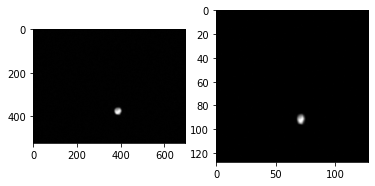

In [ ]:
randomIndx = np.random.randint(low=0,high=len(df_data))
image_name = df_data.iloc[randomIndx]['image_id']
image_path = os.path.join(path,actual_img_path,image_name)
displayImg(image_path)

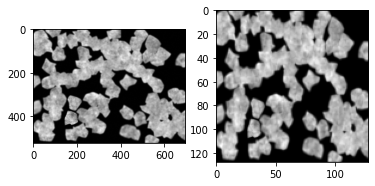

In [ ]:
image_name = df_data.iloc[randomIndx]['mask_id']
image_path = os.path.join(path,actual_img_path,image_name)
displayImg(image_path)

In [ ]:
#split data into train and test
df_x_train = df_data.iloc[:int(0.8*len(df_data))].reset_index(drop=True)
df_x_test = df_data.iloc[int(0.8*len(df_data)):].reset_index(drop=True)
print(df_x_train.shape,df_x_test.shape)

df_y_train = df_data.iloc[:int(0.8*len(df_data))].reset_index(drop=True)
df_y_test = df_data.iloc[int(0.8*len(df_data)):].reset_index(drop=True)
print(df_y_train.shape,df_y_test.shape)

(960, 2) (240, 2)
(960, 2) (240, 2)


In [ ]:
import segmentation_models as sm

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
def processImage(data,isMask=False):
    filepath = None
    x = []
    for img_id in data:
        if isMask == False:
            filepath = os.path.join(path,actual_img_path,img_id)
        else:
            filepath = os.path.join(path,ground_truth_img_path,img_id)
        img = loadImg(filepath)
        img = resizeImg(img)
        img = np.expand_dims(img,axis=-1)
        x.append(img)
    x = np.array(x)
    print(x.shape)
    if isMask == False:
        x = preprocess_input(x)
    return x

In [ ]:
x_train = processImage(df_x_train['image_id'].values)
x_test = processImage(df_x_test['image_id'].values)
y_train = processImage(df_y_train['mask_id'].values,isMask=True)
y_test = processImage(df_y_test['mask_id'].values,isMask=True)

(960, 128, 128, 1)
(240, 128, 128, 1)
(960, 128, 128, 1)
(240, 128, 128, 1)


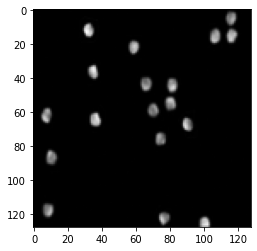

In [ ]:
plt.imshow(tf.squeeze(x_train[0]),cmap='gray')

In [ ]:
sm.set_framework('tf.keras')

In [ ]:
model = sm.Unet(BACKBONE,input_shape=(128,128,1),classes=1,
                encoder_weights=None)
model.compile(
    'Adam',
    loss= sm.losses.jaccard_loss,
    metrics=[sm.metrics.iou_score],
)

history = model.fit(
   x=x_train,
   y=y_train,
   batch_size=32,
   epochs=20,
   validation_data=(x_test, y_test),
)

Epoch 1/20
30/30 [==============================] - 6s 77ms/step - loss: -19.6766 - iou_score: 20.6766 - val_loss: -25.0396 - val_iou_score: 25.5208
Epoch 2/20
30/30 [==============================] - 2s 51ms/step - loss: -119.2378 - iou_score: 120.2378 - val_loss: -20.1052 - val_iou_score: 20.9002
Epoch 3/20
30/30 [==============================] - 2s 51ms/step - loss: -160.3416 - iou_score: 161.3416 - val_loss: -2.1258 - val_iou_score: 3.1630
Epoch 4/20
30/30 [==============================] - 2s 51ms/step - loss: -171.4505 - iou_score: 172.4505 - val_loss: -19.5431 - val_iou_score: 20.3415
Epoch 5/20
30/30 [==============================] - 2s 51ms/step - loss: -175.6896 - iou_score: 176.6896 - val_loss: 0.9996 - val_iou_score: 3.4143e-04
Epoch 6/20
30/30 [==============================] - 2s 51ms/step - loss: -177.7217 - iou_score: 178.7217 - val_loss: -1.5391 - val_iou_score: 2.5564
Epoch 7/20
30/30 [==============================] - 2s 51ms/step - loss: -179.2546 - iou_score: 180

In [ ]:
# model.summary()

In [ ]:
def displayImages(org,pre,gt=None,withLbl=False):
    origin = org
    pred = pre
    if withLbl == False:
        fig,ax = plt.subplots(1,2,figsize=(10,10))
        ax[0].set_title('Original Image')
        ax[0].imshow(origin,cmap='gray')
        ax[1].set_title('Predicted Image')
        ax[1].imshow(pred,cmap='gray')
    else:
        fig,ax = plt.subplots(1,3,figsize=(15,15))
        ax[0].set_title('Original Image')
        ax[0].imshow(origin,cmap='gray')
        ax[1].set_title('Ground truth Image')
        ax[1].imshow(gt,cmap='gray')
        ax[2].set_title('Predicted Image')
        ax[2].imshow(pred,cmap='gray')


In [ ]:
def loadProperImage(filepath):
    img = loadImg(filepath)
    img = resizeImg(img)
    img = np.expand_dims(img,axis=-1)
    x = img
    x = np.array(x)
    return x

In [ ]:
def model_prediction(filepath,model,maskPath=None):
    x = loadProperImage(filepath)
    x = np.array([preprocess_input(x)])
    pred = model.predict(x)[0]
    pred_img = np.squeeze(pred)
    img = np.squeeze(x) 
    if maskPath == None:
        displayImages(img,pred_img)
    else:
        lbl = loadProperImage(maskPath)
        lbl = np.squeeze(lbl) 
        displayImages(img,pred_img,lbl,True)

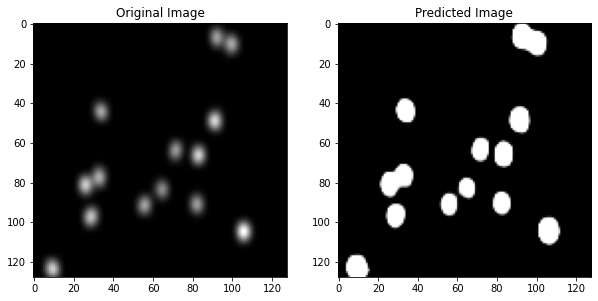

In [ ]:
img_id = actual_img[np.random.randint(0,len(actual_img))]
if img_id not in df_data['image_id'].values:
    filepath = os.path.join(path,actual_img_path,img_id)
    maskPath = os.path.join(path,ground_truth_img_path,img_id)
    model_prediction(filepath,model)


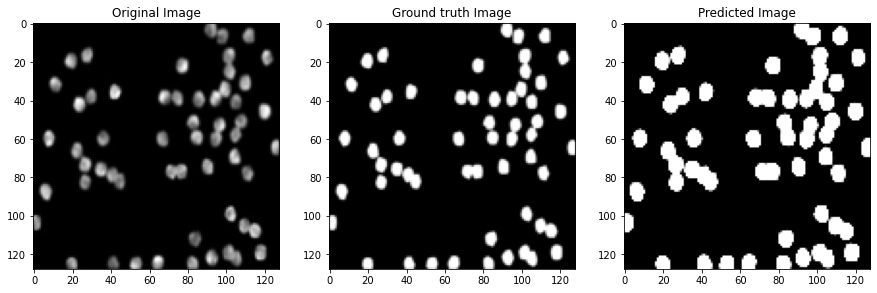

In [ ]:
img_id = df_data.iloc[np.random.randint(0,len(df_data))]['mask_id']
if img_id in df_data['image_id'].values:
    filepath = os.path.join(path,actual_img_path,img_id)
    maskPath = os.path.join(path,ground_truth_img_path,img_id)
    model_prediction(filepath,model,maskPath)
